Due to the nature of the dataset being extremely imbalanced (only .172% fraud), it's unreasonable to judge the effectiveness of the model using accuracy, as it will be overrepresenting the "correct" choices of when it isn't a fraud (~99% of cases)

In [2]:
#from google.colab import files
#uploaded = files.upload()

Saving creditcard.csv to creditcard.csv


In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.ensemble import HistGradientBoostingClassifier


df = pd.read_csv("creditcard.csv")

# Separate features and label
X = df.drop("Class", axis=1)
y = df["Class"]

# Train/Validation Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale ONLY Time and Amount (others already PCA'd)
scaler = StandardScaler()

X_train[["Time", "Amount"]] = scaler.fit_transform(X_train[["Time", "Amount"]])
X_test[["Time", "Amount"]] = scaler.transform(X_test[["Time", "Amount"]])

# Train HistGradientBoostingClassifier


model = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=6,
    max_iter=300,
    l2_regularization=1.0,
    min_samples_leaf=20,
    early_stopping=True,
    class_weight="balanced"     # IMPORTANT FOR IMBALANCE
)

print("Training HistGradientBoostingClassifier...")
model.fit(X_train, y_train)

# Use probability for metrics
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Recommended metric for this dataset: **Average Precision (PR-AUC)**
pr_auc = average_precision_score(y_test, y_pred_proba)

roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n===== RESULTS =====")
print(f"PR-AUC:  {pr_auc:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")


y_pred_proba = model.predict_proba(X_test)[:, 1]




Training model...

===== RESULTS =====
PR-AUC:  0.7322
ROC-AUC: 0.9675


In [13]:
def predict_fraud(model, scaler, row_dict):
    df_input = pd.DataFrame([row_dict])

    # Scale Time + Amount
    df_input[["Time", "Amount"]] = scaler.transform(df_input[["Time", "Amount"]])

    # Predict fraud probability
    proba = model.predict_proba(df_input)[0][1]
    return proba


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Plots the ROC curve and prints the AUC.
def plot_roc_curve(y_test, y_pred_proba):


    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plots the Precision-Recall curve and prints the Average Precision score.

def plot_precision_recall_curve(y_test, y_pred_proba):

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(7, 5))
    plt.plot(recall, precision, label=f"AP = {pr_auc:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


Testing new transactions (And taking groups of datasets to see if it works, such as a portion, or all frauds)

Testing the first 20 rows from the dataset (note, none of these are frauds). You may set any number (n) to test n rows:

In [14]:
n = 20
subset = X_test.iloc[:n]
probs = model.predict_proba(subset)[:, 1]
preds = model.predict(subset)

print(probs)
print(preds)


[0.02964064 0.02990454 0.19576041 0.0299343  0.03030593 0.03692757
 0.0299343  0.0299343  0.03025584 0.0299343  0.1099397  0.05194048
 0.0299343  0.02987192 0.0299343  0.02990454 0.02981544 0.0299343
 0.0299343  0.03492617]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Testing on only frauds to see how well it detects them:

In [12]:
frauds = df[df["Class"] == 1].drop("Class", axis=1).copy()

# scale the fraud rows
frauds[["Time", "Amount"]] = scaler.transform(frauds[["Time", "Amount"]])

fraud_probs = model.predict_proba(frauds)[:, 1]
fraud_preds = model.predict(frauds)

print("Percent of frauds detected:",
      fraud_preds.mean() * 100, "%")


Percent of frauds detected: 95.9349593495935 %


ROC-AUC and PR-AUC (Recommended from the dataset to use as it's heavily imbalanced. ROC-AUC will be skewed very highly as it will get many true negatives as it's over 99% of the plots, and is more commonly assigned):

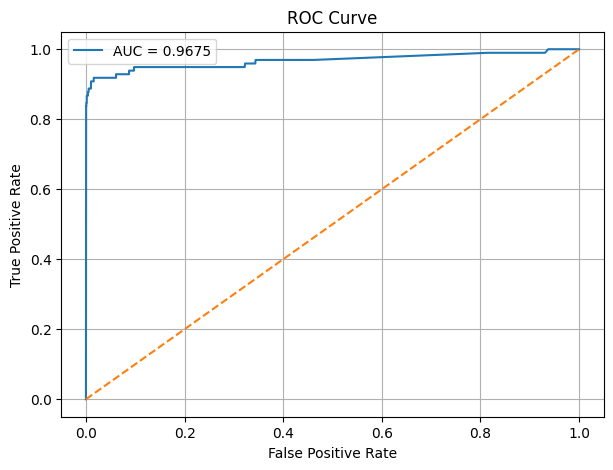

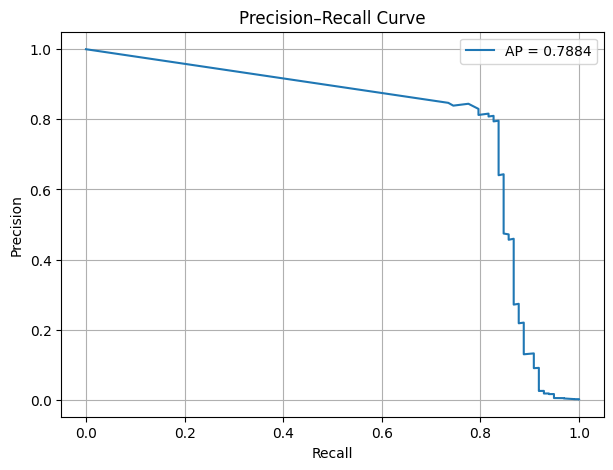

In [16]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

plot_roc_curve(y_test, y_pred_proba)
plot_precision_recall_curve(y_test, y_pred_proba)


x-axis = recall (how many frauds are correctly caught)
y-axis = precision (when it says fraud, how often it's actually correct)
for each possible probability threshold

Near 0, we have a high chance of not missassigning a fraud, but we may not catch every fraud, as we move to a higher threshold (i.e. 1) we may find more frauds, but we'll also get a few false alarms. As we get closer the max, since most aren't frauds, we will have many false alarms.